In [14]:
import importlib
import micasense.capture
import cv2
import os, glob
import json
import pickle #This library will maintain the format as well
from osgeo import gdal,osr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image as Image
import datetime
from math import ceil
from tqdm import tqdm
import re
import glob
from PIL import Image

import algorithms.flight_attributes
import algorithms.validate_algorithm
import algorithms.select_GPS as SelectGPS
import algorithms.georeferencing

importlib.reload(algorithms.flight_attributes)
importlib.reload(algorithms.georeferencing)

import algorithms.flight_attributes as FlightAttributes
import algorithms.georeferencing as georeferencing

## Import data that has been processed by the Micasense's image processing library

In [15]:
imagePath = r"D:\EPMC_flight\pandanRes\00angle_15H_50overlap"
rawImagePath = os.path.join(imagePath,'RawImg') # We created a new folder called RawImg to store all the raw images here
flightAttributesPath = os.path.join(imagePath,'flight_attributes','flight_attributes.csv')
if os.path.exists(flightAttributesPath):
    log = pd.read_csv(flightAttributesPath)
log.head()

,timestamp,latitude,longitude,altitude,image_name,capture_id,dls-yaw,dls-pitch,dls-roll,irr-475,irr-560,irr-668,irr-842,irr-717,irr-444,irr-531,irr-650,irr-705,irr-740
0,2023-09-20 02:37:46.734108+00:00,1.318984,103.736576,30.643,IMG_0000_1.tif,iRMg5hgGW1CUYi1x0TlZ,0.635662,-0.207969,-0.047398,0.744841,0.663156,0.547643,0.342493,0.428046,0.670643,0.687768,0.544391,0.483355,0.445280
1,2023-09-20 02:38:25.652070+00:00,1.318969,103.736552,31.828,IMG_0001_1.tif,ws9iE0ctR0GdjP9XYeKY,1.768777,-0.081365,-0.034487,1.422521,1.305924,1.134642,0.701718,0.873402,1.247496,1.338475,1.114349,0.995491,0.917994
2,2023-09-20 02:40:02.646889+00:00,1.318935,103.736667,31.825,IMG_0002_1.tif,o34Xx90IfaznKeSuG8Bq,1.807706,-0.066323,-0.019898,0.403826,0.350253,0.274099,0.171907,0.214341,0.371606,0.366940,0.274736,0.241525,0.222003
3,2023-09-20 02:40:27.129650+00:00,1.318957,103.736711,43.093,IMG_0003_1.tif,9uaW8y0N0EE0vgF9zbKj,0.603067,-0.147849,0.018589,0.394172,0.341704,0.268347,0.168132,0.209751,0.362208,0.357995,0.268675,0.236576,0.217652
4,2023-09-20 02:40:28.687747+00:00,1.318989,103.736740,43.126,IMG_0004_1.tif,573tCs56BPBA8nQJo06y,0.632837,-0.131004,0.014908,0.393962,0.341402,0.268274,0.168016,0.209701,0.361889,0.357701,0.268546,0.236570,0.217697


## View flight altitude

In [16]:
# helper function that is only relevant to my file naming. I named my imagePath folder as the UAV height e.g. ...15H...
# this step is (optional)
height_dict = FlightAttributes.get_heights(imagePath,log)
height_dict

offset height: 26m


{'measuredHeight': 41.295,
 'actualHeight': 15,
 'height_max': 52.609,
 'height_min': 23.956,
 'DEM_offset_height': 26}

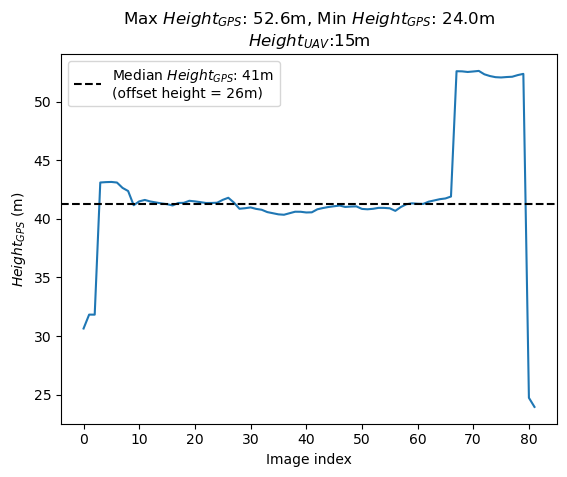

In [17]:
plt.figure()
plt.plot(log.index.to_list(),log['altitude'])
height_max = height_dict['height_max']
height_min = height_dict['height_min']
measuredHeight = height_dict['measuredHeight']
actualHeight = height_dict['actualHeight']
DEM_offset_height = height_dict['DEM_offset_height']
plt.axhline(y=measuredHeight, ls='--',c='k',label=r'Median $Height_{GPS}$:' f" {int(measuredHeight)}m\n(offset height = {DEM_offset_height}m)")
plt.title(r'Max $Height_{GPS}$:' + f' {height_max:.1f}m, ' + r'Min $Height_{GPS}$: ' + f'{height_min:.1f}m\n' + r'$Height_{UAV}$:' +f'{actualHeight}m')
plt.ylabel(r'$Height_{GPS}$ (m)')
plt.xlabel('Image index')
plt.legend()
# save fig
parentDir = os.path.join(os.path.dirname(imagePath),"images")
os.mkdir(parentDir) if not os.path.exists(parentDir) else None
fname = os.path.join(parentDir,f'height_timeseries.png')
plt.savefig(fname)

plt.show()

## Detect points/Import GPS points

[10, 15, 19, 25, 29, 35, 39, 45, 49, 55, 59, 65]


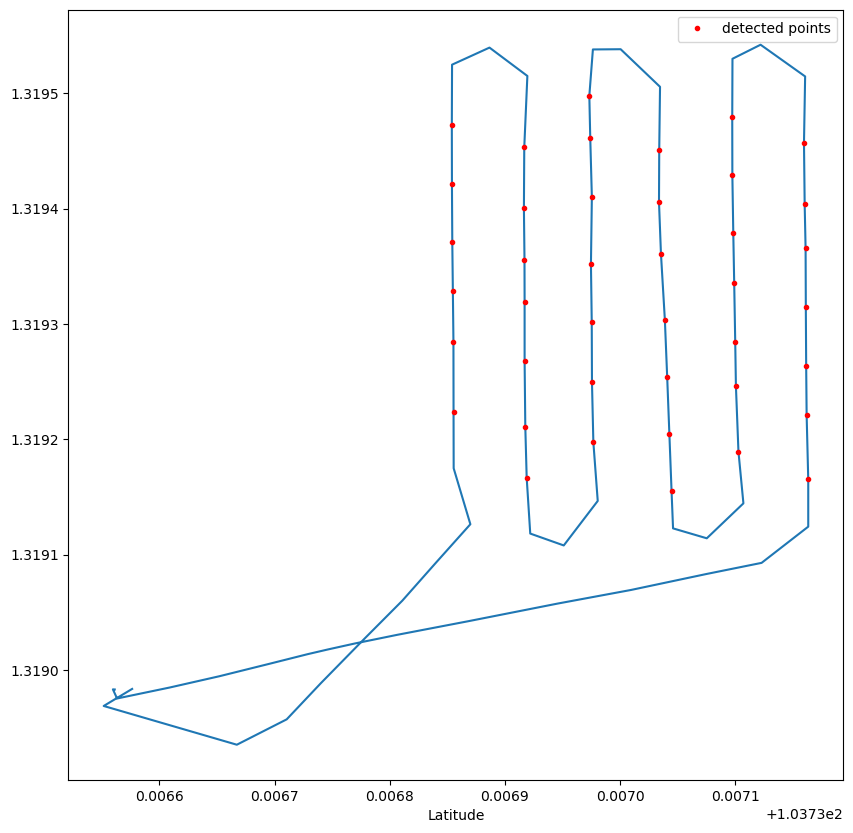

[10, 11, 12, 13, 14, 15, 19, 20, 21, 22, 23, 24, 25, 29, 30, 31, 32, 33, 34, 35, 39, 40, 41, 42, 43, 44, 45, 49, 50, 51, 52, 53, 54, 55, 59, 60, 61, 62, 63, 64, 65]


In [18]:
# import GPS points
ls_idx = SelectGPS.readSelectedGPS(rawImagePath)
# print(ls_idx)
# plot selected GPS points
DL = SelectGPS.DetectLines(log, n = 3, thresh=0.99, plot=True)
flight_points = DL.get_points(flight_points = ls_idx)
print(flight_points)

# No correction

shape of canvas(4707, 4687, 3)


,timestamp,latitude,longitude,altitude,image_name,capture_id,dls-yaw,dls-pitch,dls-roll,irr-475,irr-560,irr-668,irr-842,irr-717,irr-444,irr-531,irr-650,irr-705,irr-740,flight_angle
10,2023-09-20 02:40:46.867245+00:00,1.319223,103.736855,17.528,IMG_0010_1.tif,TGMjtoMK4lZZHwz0gWE2,0.098322,-0.067554,-0.011150,0.389261,0.336241,0.263961,0.165486,0.207043,0.357777,0.352711,0.264435,0.233321,0.214836,-5.633421
11,2023-09-20 02:40:48.333197+00:00,1.319285,103.736855,17.650,IMG_0011_1.tif,Vbmk53xTHky4YeQ3tY5q,0.105641,-0.061187,-0.012180,0.388711,0.335740,0.263521,0.165222,0.206712,0.357304,0.352196,0.264010,0.232936,0.214483,-6.052807
12,2023-09-20 02:40:49.529728+00:00,1.319329,103.736855,17.519,IMG_0012_1.tif,sHfimxse9xw3yckAG5jT,0.108555,-0.092849,-0.016617,0.388261,0.335334,0.263198,0.165027,0.206479,0.356898,0.351778,0.263695,0.232662,0.214233,-6.219740
13,2023-09-20 02:40:50.856883+00:00,1.319371,103.736854,17.435,IMG_0013_1.tif,JTvwKvY3Wp1QRFABs177,0.120106,-0.088623,-0.023227,0.387690,0.334802,0.262754,0.164750,0.206159,0.356389,0.351234,0.263266,0.232289,0.213892,-6.881566
14,2023-09-20 02:40:52.169954+00:00,1.319422,103.736854,17.352,IMG_0014_1.tif,GSCS3gkaTUELPKSWJdea,0.124905,-0.094922,-0.029860,0.387213,0.334354,0.262390,0.164522,0.205883,0.355956,0.350776,0.262902,0.231979,0.213612,-7.156555


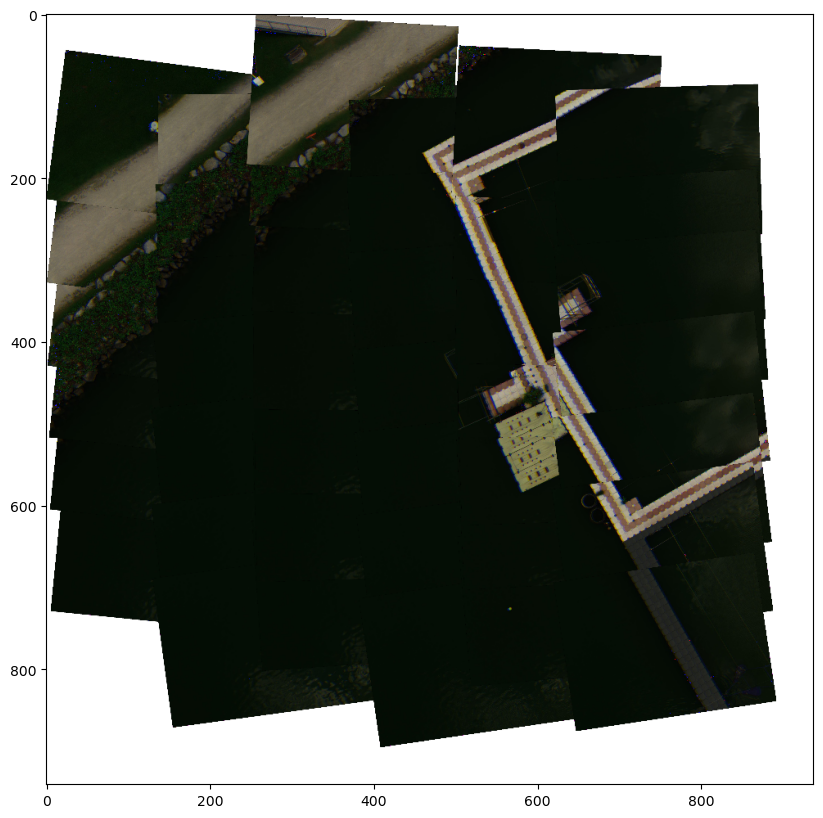

In [19]:
DEM_offset_height = height_min
df_cropped = log.iloc[flight_points,:]
#----------------append flight angle---------------------------------------------
df_cropped.loc[:,['flight_angle']] = -df_cropped['dls-yaw']/np.pi*180
#-----------adjust UAV's altitude instead of using GPS's altitude reading--------
df_cropped.loc[:,['altitude']] = df_cropped.loc[:,['altitude']] - DEM_offset_height
# view georeferenced images using mpl
PG = FlightAttributes.PlotGeoreference(imagePath,df_cropped)
im_display = PG.plot_georeference(reduction_factor=5,plot=True)
df_cropped.head()

## Interpolate Flight
- estimate flight angle using coordinates (`estimate_angle = "coord"`)
- estimate flight angle using yaw (`estimate_angle = "yaw"`)

82it [00:00, 1588.96it/s]


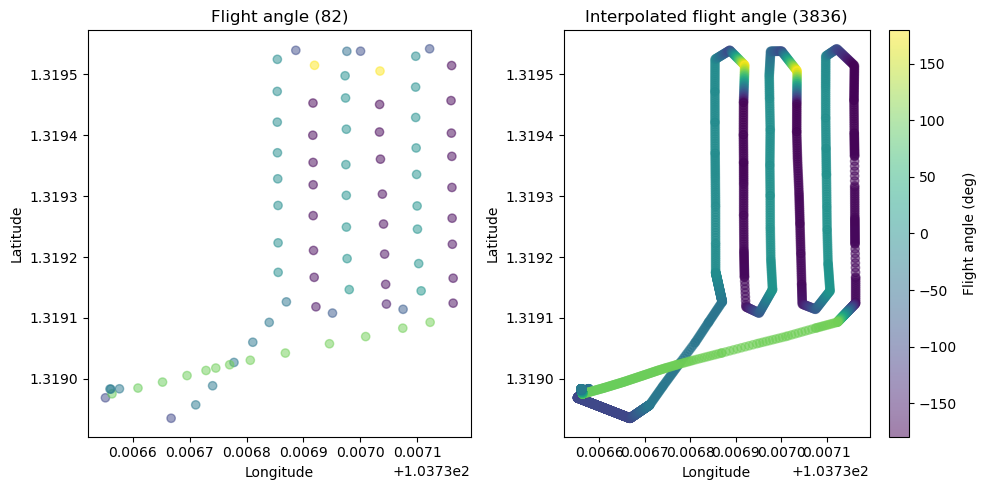

,timestamp,timedelta,latitude,longitude,altitude,flight_angle,north_vec,east_vec,image_name,capture_id,...,irr-560,irr-668,irr-842,irr-717,irr-444,irr-531,irr-650,irr-705,irr-740,index
0,2023-09-20 02:37:46.734108+00:00,0.0,1.318984,103.736576,30.643000,-36.420749,-1.0,1.0,IMG_0000_1.tif,iRMg5hgGW1CUYi1x0TlZ,...,0.663156,0.547643,0.342493,0.428046,0.670643,0.687768,0.544391,0.483355,0.44528,0
1,2023-09-20 02:37:46.834108+00:00,0.1,1.318984,103.736576,30.646045,-36.587568,-1.0,1.0,IMG_0000_1.tif,iRMg5hgGW1CUYi1x0TlZ,...,0.663156,0.547643,0.342493,0.428046,0.670643,0.687768,0.544391,0.483355,0.44528,0
2,2023-09-20 02:37:46.934108+00:00,0.2,1.318984,103.736576,30.649090,-36.754387,-1.0,1.0,IMG_0000_1.tif,iRMg5hgGW1CUYi1x0TlZ,...,0.663156,0.547643,0.342493,0.428046,0.670643,0.687768,0.544391,0.483355,0.44528,0
3,2023-09-20 02:37:47.034108+00:00,0.3,1.318983,103.736576,30.652135,-36.921207,-1.0,1.0,IMG_0000_1.tif,iRMg5hgGW1CUYi1x0TlZ,...,0.663156,0.547643,0.342493,0.428046,0.670643,0.687768,0.544391,0.483355,0.44528,0
4,2023-09-20 02:37:47.134108+00:00,0.4,1.318983,103.736576,30.655179,-37.088026,-1.0,1.0,IMG_0000_1.tif,iRMg5hgGW1CUYi1x0TlZ,...,0.663156,0.547643,0.342493,0.428046,0.670643,0.687768,0.544391,0.483355,0.44528,0


In [9]:
IF = FlightAttributes.InterpolateFlight(log, 
                                        interpolate_milliseconds=100, 
                                        estimate_angle = "yaw")
df_interpolated = IF.interpolate_flight()
df_interpolated.head()

# Time delay correction

- identify the optimal time delay for obtaining the optimal image alignment
- identify the optimal height for obtaining the accurate projection

82it [00:00, 1393.56it/s]


rows shifted: -10
shape of canvas(5357, 4679, 3)
rows shifted: -8
shape of canvas(5296, 4679, 3)
rows shifted: -7
shape of canvas(5234, 4684, 3)
rows shifted: -5
shape of canvas(5047, 4686, 3)
rows shifted: -4
shape of canvas(4954, 4686, 3)
rows shifted: -2
shape of canvas(4808, 4686, 3)
rows shifted: -1
shape of canvas(4757, 4687, 3)
rows shifted: 0
shape of canvas(4707, 4687, 3)


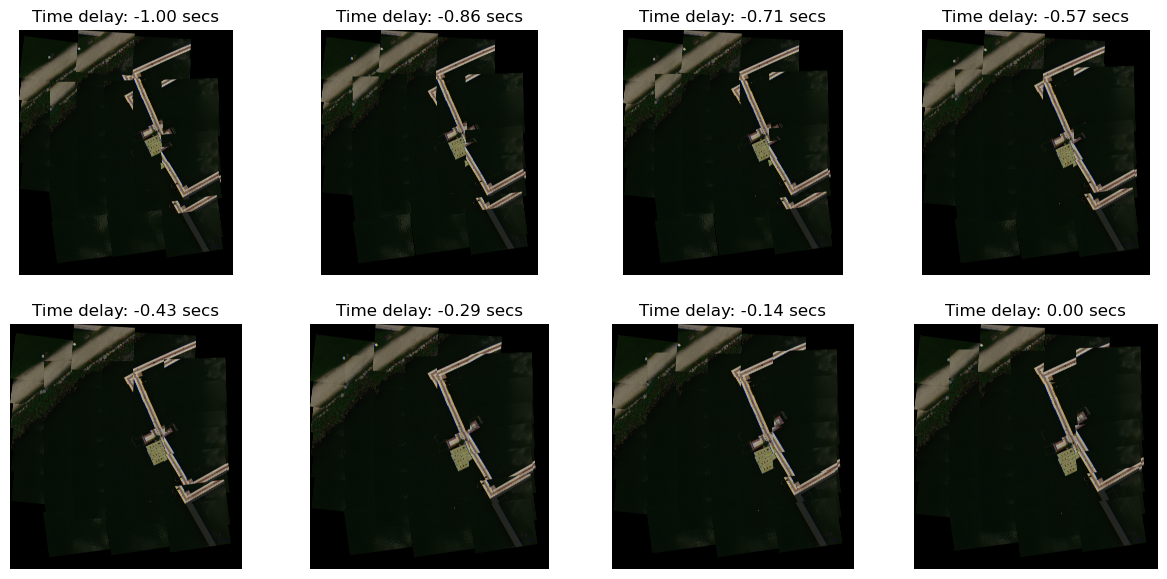

In [20]:
# estimate the bounds of time delay correction
est_time_delay1 = 0
est_time_delay2 = -1
# indicate what method to estimate flight_angle in `estimate_angle`: "yaw" or "coord"
estimate_angle = "yaw"
# because imaging may not be conducted at MSL, water body may be located a few meters above MSL. Use minimum height recorded in the GPS module to estimate the altitude of the water body
DEM_offset_height = height_min
IF = FlightAttributes.InterpolateFlight(log, 
                                        interpolate_milliseconds=100, 
                                        estimate_angle = estimate_angle)
df_interpolated = IF.interpolate_flight(plot=False)

n_fig = 8
fig, axes = plt.subplots(2,4, figsize=(15,7))

for i, (td,ax) in enumerate(zip(np.linspace(est_time_delay2,est_time_delay1, n_fig),axes.flatten())):
    df1 = FlightAttributes.time_delta_correction(df_interpolated, timedelta=td, 
                                                 columns_to_shift = ['timestamp', 'timedelta', 'latitude', 'longitude'])
    df_cropped = df1.iloc[flight_points,:]
    #----------------append flight angle---------------------------------------------
    df_cropped.loc[:,['flight_angle']] = -df_cropped['dls-yaw']/np.pi*180
    #-----------adjust UAV's altitude instead of using GPS's altitude reading--------
    df_cropped.loc[:,['altitude']] = df_cropped.loc[:,['altitude']] - DEM_offset_height
    PG = FlightAttributes.PlotGeoreference(imagePath,df_cropped)
    im_display = PG.plot_georeference(reduction_factor=5,plot=False)
    ax.imshow(im_display)
    ax.axis('off')
    ax.set_title(f'Time delay: {td:.2f} secs')
plt.show()

# Georeference corrected images

## View corrected images

rows shifted: -2
shape of canvas(4808, 4686, 3)


,level_0,timestamp,timedelta,latitude,longitude,altitude,flight_angle,north_vec,east_vec,image_name,...,irr-560,irr-668,irr-842,irr-717,irr-444,irr-531,irr-650,irr-705,irr-740,index
10,1807,2023-09-20 02:40:47.067245+00:00,180.333137,1.319232,103.736855,17.528,-5.633421,1.0,-1.0,IMG_0010_1.tif,...,0.336241,0.263961,0.165486,0.207043,0.357777,0.352711,0.264435,0.233321,0.214836,10
11,1822,2023-09-20 02:40:48.533197+00:00,181.799089,1.319292,103.736855,17.650,-6.052807,1.0,-1.0,IMG_0011_1.tif,...,0.335740,0.263521,0.165222,0.206712,0.357304,0.352196,0.264010,0.232936,0.214483,11
12,1834,2023-09-20 02:40:49.729728+00:00,182.995620,1.319335,103.736855,17.519,-6.219740,1.0,-1.0,IMG_0012_1.tif,...,0.335334,0.263198,0.165027,0.206479,0.356898,0.351778,0.263695,0.232662,0.214233,12
13,1848,2023-09-20 02:40:51.056883+00:00,184.322775,1.319379,103.736854,17.435,-6.881566,1.0,-1.0,IMG_0013_1.tif,...,0.334802,0.262754,0.164750,0.206159,0.356389,0.351234,0.263266,0.232289,0.213892,13
14,1862,2023-09-20 02:40:52.369954+00:00,185.635846,1.319429,103.736854,17.352,-7.156555,1.0,-1.0,IMG_0014_1.tif,...,0.334354,0.262390,0.164522,0.205883,0.355956,0.350776,0.262902,0.231979,0.213612,14


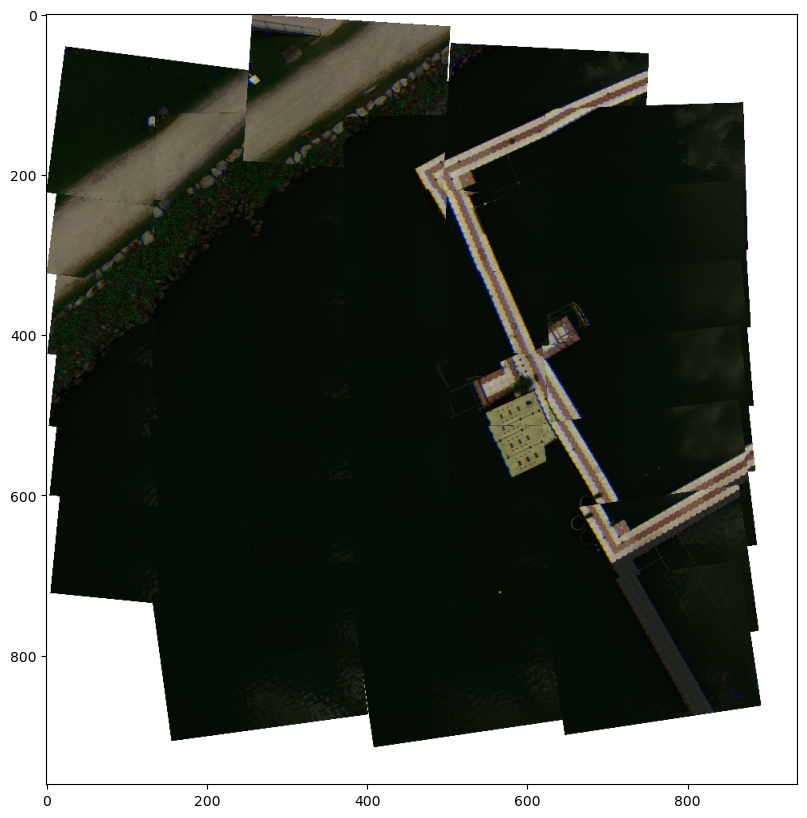

In [21]:
td = -0.29
DEM_offset_height = height_min
df1 = FlightAttributes.time_delta_correction(df_interpolated, timedelta=td, 
                                                 columns_to_shift = ['timestamp', 'timedelta', 'latitude', 'longitude'])
df_cropped = df1.iloc[flight_points,:]
#----------------append flight angle---------------------------------------------
df_cropped.loc[:,['flight_angle']] = -df_cropped['dls-yaw']/np.pi*180
#-----------adjust UAV's altitude instead of using GPS's altitude reading--------
df_cropped.loc[:,['altitude']] = df_cropped.loc[:,['altitude']] - DEM_offset_height
PG = FlightAttributes.PlotGeoreference(imagePath,df_cropped)
im_display = PG.plot_georeference(reduction_factor=5,plot=True)
df_cropped.head()

In [ ]:
for image_index, rows in df_cropped.iterrows():
    lat = rows['latitude']
    lon = rows['longitude']
    alt = rows['altitude']
    pitch = rows['dls-pitch']
    roll = rows['dls-roll']
    yaw = rows['dls-yaw']
    image_name = rows['image_name']
    print(f'[{image_index}] {image_name}')
    flight_angle = rows['flight_angle']
    georeferencing.directGeoreferencing_gdal(imagePath,image_name,lat,lon,alt,flight_angle,
                                             dirname=f"timeDelay_alt{int(measuredHeight - DEM_offset_height)}")